# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

In [57]:
tickers = ['NVDA', 'META', 'GOOG', 'AAPL', 'AMZN']

yrs = 10

start_date = dt.datetime.today()-dt.timedelta(days = yrs*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  5 of 5 completed


In [ ]:
close = stock['Close']
normalized_returns = close/close.iloc[0]-1
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
stock = pd.concat([stock, normalized_returns], axis =1 )


In [59]:
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

daily_returns

Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2015-05-28,-0.001971,-0.011306,-0.000019,-0.004978,0.013643
2015-05-29,-0.011448,0.006216,-0.014311,-0.012050,-0.000452
2015-06-01,0.001994,0.003930,0.003527,0.013795,0.011234
2015-06-02,-0.004453,0.000162,0.009672,0.001866,-0.019856
2015-06-03,0.001230,0.012910,0.002094,0.024559,-0.010999
...,...,...,...,...,...
2025-05-19,-0.011809,0.002769,0.002625,0.000140,0.001255
2025-05-20,-0.009239,-0.010189,-0.015307,-0.005213,-0.008817
2025-05-21,-0.023329,-0.014561,0.028268,-0.002515,-0.019386


In [60]:
from scipy.stats import norm 

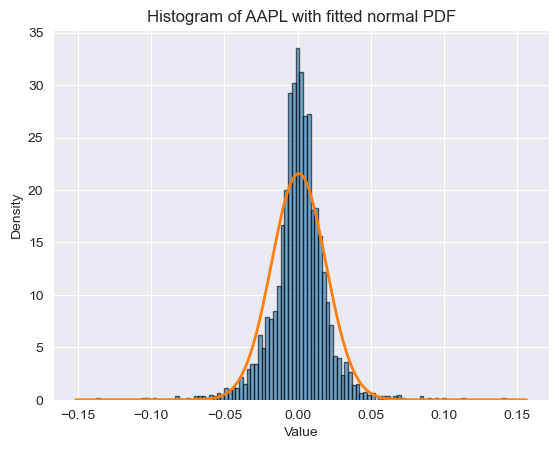

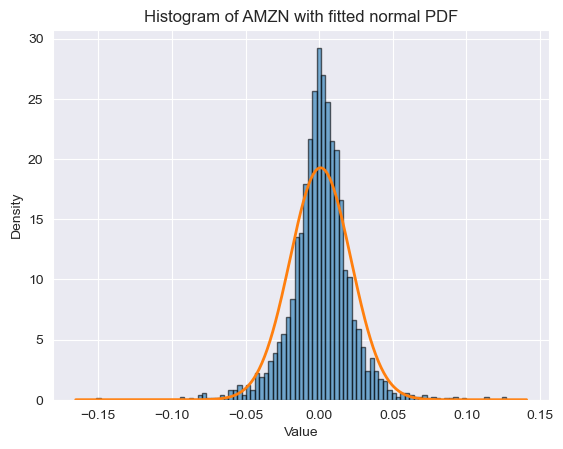

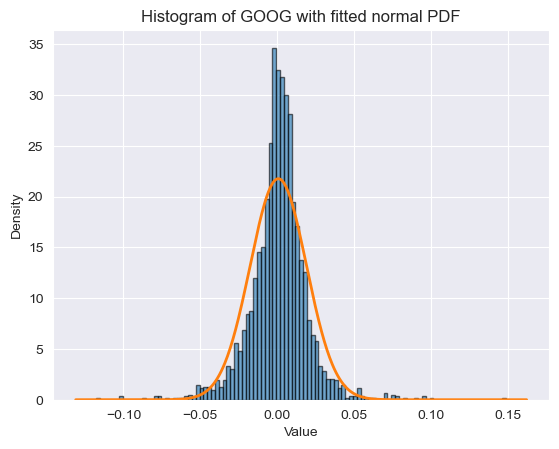

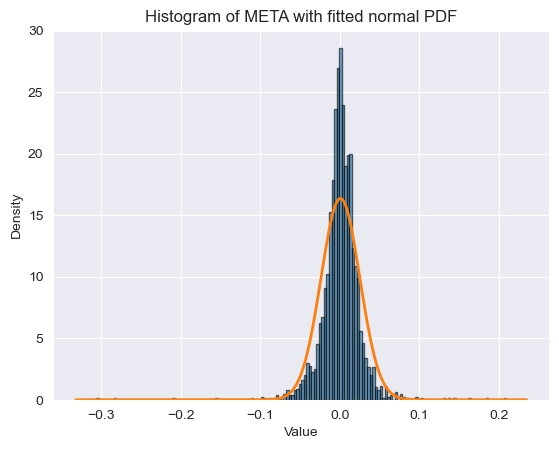

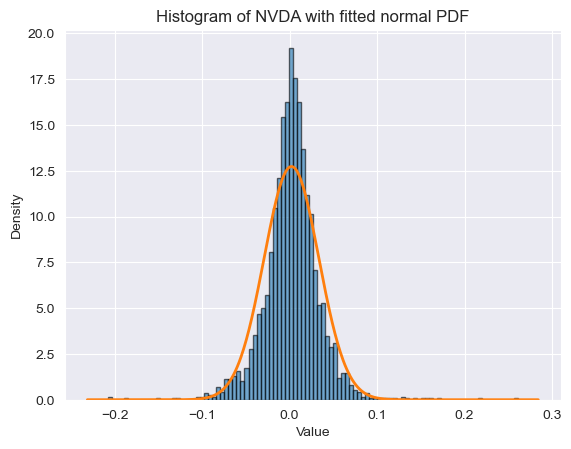

In [73]:
for ticker in daily_returns.columns:
        mu, sigma = daily_returns[ticker].mean(), daily_returns[ticker].std(ddof=1)
        fig, ax = plt.subplots()
        # “density=True” rescales bar heights so the total area = 1,
        # which puts the histogram on the same scale as a PDF.
        ax.hist(daily_returns[ticker],
        bins="auto",           # can also set this manually
        density=True,
        edgecolor="k",
        alpha=0.6)

        # make the corresponding normal PDF curve
        xmin, xmax = ax.get_xlim()             # span of the plotted data
        x = np.linspace(xmin, xmax, 500)
        ax.plot(x, norm.pdf(x, mu, sigma),      # norm.pdf evaluates N(mu,sigma**2)
                linewidth=2)


        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Histogram of {ticker} with fitted normal PDF")
        plt.show()

### Do tests for normality

* Shapiro-Wilk:	test for general departures (skew, kurtosis, shape)
* Jarque–Bera: tests for skewness + kurtosis
* D'Agostino–Pearson $K^2$: joint skew–kurtosis, more power than JB

In [107]:
from scipy import stats

def normality_tests(col):
    """Return a dict of p-values/statistics for one Series."""
    s = col.dropna() # get rid of null values
    
    w,  p_shapiro = stats.shapiro(s)
    jb, p_jb      = stats.jarque_bera(s)
    k2, p_k2      = stats.normaltest(s)   # D’Agostino–Pearson
    
    return {
        "Shapiro p"   : p_shapiro,
        "Jarque-Bera p": p_jb,
        "D-P K^2 p"     : p_k2,
    }

In [70]:
results = daily_returns.apply(normality_tests).T        # one row per column
for ticker in daily_returns.columns:
    print(ticker, results[ticker])

AAPL {'Shapiro p': np.float64(2.3639468270561856e-32), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(3.4178083786908e-75)}
AMZN {'Shapiro p': np.float64(3.175890389067233e-30), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(2.455675763805353e-62)}
GOOG {'Shapiro p': np.float64(2.7919569289060334e-32), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(8.722089635465252e-71)}
META {'Shapiro p': np.float64(2.6653015777406766e-44), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(2.720060970322374e-230)}
NVDA {'Shapiro p': np.float64(3.9950028742200854e-31), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(1.6068951297941583e-78)}


These $p$-values are very nearly 0, such as $10^{-266}$. This is because some of the test like Jarque-Bera are designed to be sensitive to skew and kurtosis. We'll show below that we do have skew and excess kurtosis (the default when calling kurtosis is usually excess kurtosis where we've already subtracted off 3).

In [64]:
stats = daily_returns.agg(['mean', 'std', 'skew', 'kurtosis']).T
print(stats.round(3))


         mean    std   skew  kurtosis
Ticker                               
AAPL    0.001  0.019 -0.103     6.395
AMZN    0.001  0.021  0.005     5.026
GOOG    0.001  0.018  0.015     5.972
META    0.001  0.024 -1.145    25.684
NVDA    0.002  0.031  0.142     6.709


### Get rid of extremes by taking the middle 95th quantile

In [65]:
central95 = daily_returns.quantile([0.025, 0.975])

lower = central95.loc[0.025]
upper = central95.loc[0.975]

#mask = daily_returns.ge(lower) & daily_returns.le(upper)     # element-wise comparisons
#mask_all = mask.all(axis=1)            # row is True only if all 5 conditions hold
mid95 = daily_returns.where(daily_returns.ge(lower) & daily_returns.le(upper)) # each column now contains the middle 95% of the original columns


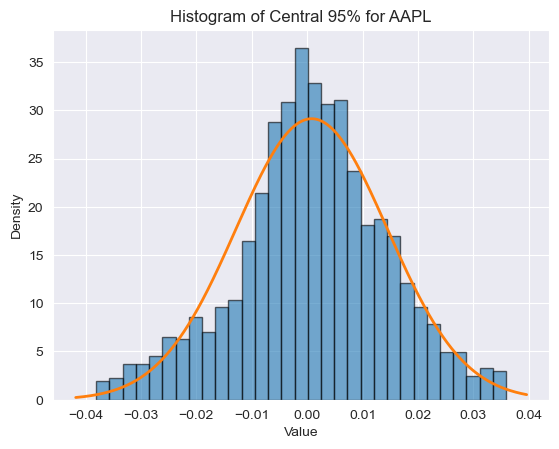

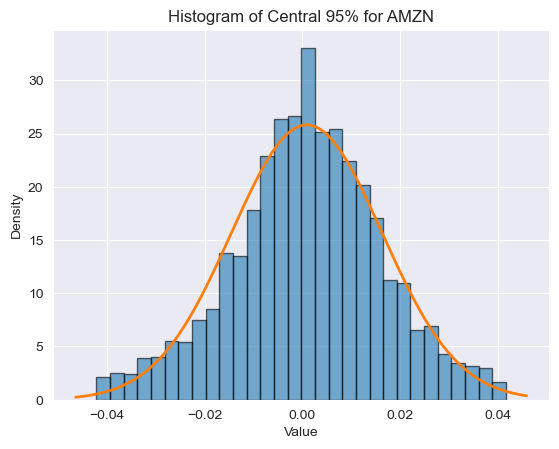

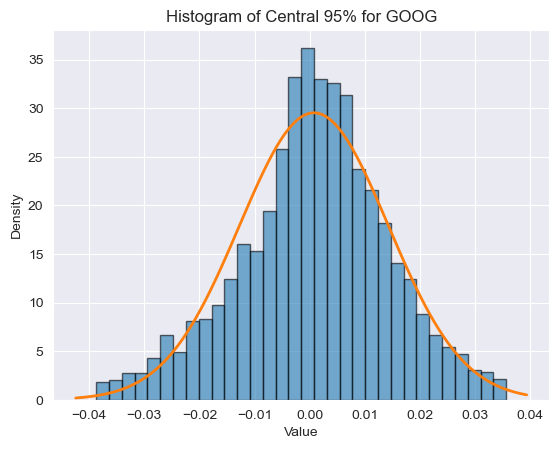

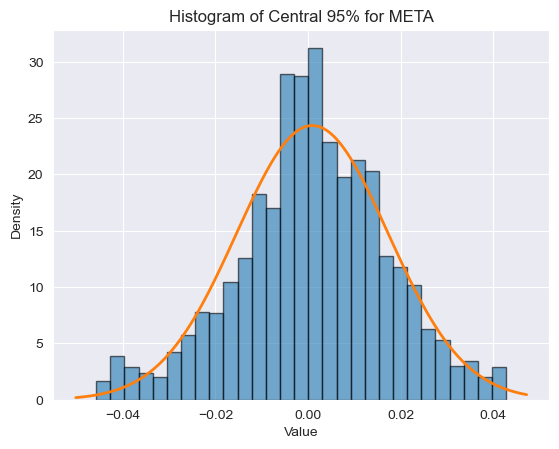

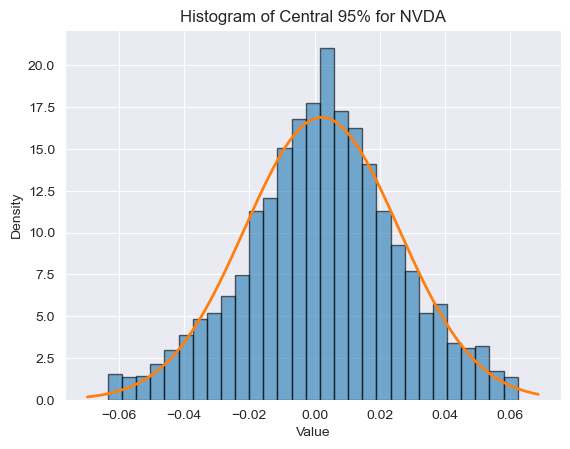

In [66]:
for ticker in mid95.columns:
        mu, sigma = mid95[ticker].mean(), mid95[ticker].std(ddof=1)
        fig, ax = plt.subplots()
        # “density=True” rescales bar heights so the total area = 1,
        # which puts the histogram on the same scale as a PDF.
        ax.hist(mid95[ticker],
        bins="auto",           # can also set this manually
        density=True,
        edgecolor="k",
        alpha=0.6)

        # make the corresponding normal PDF curve
        xmin, xmax = ax.get_xlim()             # span of the plotted data
        x = np.linspace(xmin, xmax, 500)
        ax.plot(x, norm.pdf(x, mu, sigma),      # norm.pdf evaluates N(mu,sigma**2)
                linewidth=2)


        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Histogram of Central 95% for {ticker}")
        plt.show()

We'll do some normality tests for the middle 95%; since this gets rid of the heavy tails, we expect to have higher $p$-values this time due to lack of kurtosis.

In [71]:
results = mid95.apply(normality_tests).T        # one row per column
for ticker in mid95.columns:
    print(ticker, results[ticker])

AAPL {'Shapiro p': np.float64(1.339247557083094e-09), 'Jarque-Bera p': np.float64(0.0010486970884558654), 'D-P K^2 p': np.float64(0.0011035799508700404)}
AMZN {'Shapiro p': np.float64(5.067168311985474e-07), 'Jarque-Bera p': np.float64(0.037272329157126534), 'D-P K^2 p': np.float64(0.036044718379425925)}
GOOG {'Shapiro p': np.float64(7.964225460469127e-10), 'Jarque-Bera p': np.float64(1.2485430384705027e-05), 'D-P K^2 p': np.float64(1.5382423732557752e-05)}
META {'Shapiro p': np.float64(2.4520424179034187e-09), 'Jarque-Bera p': np.float64(0.00013832234307855043), 'D-P K^2 p': np.float64(0.00016692580567384787)}
NVDA {'Shapiro p': np.float64(1.554373861132099e-06), 'Jarque-Bera p': np.float64(0.11999253068085149), 'D-P K^2 p': np.float64(0.11953774715439118)}


In [68]:
stats = mid95.agg(['mean', 'std', 'skew', 'kurtosis']).T
print(stats.round(3))


         mean    std   skew  kurtosis
Ticker                               
AAPL    0.001  0.014 -0.174     0.135
AMZN    0.001  0.015 -0.120     0.096
GOOG    0.001  0.014 -0.227     0.146
META    0.001  0.016 -0.192     0.180
NVDA    0.002  0.024 -0.103     0.001


# S&P 500

We'll get a random stock from the S&P 500 and we'll also just work with the S&P 500 as its own financial instrument.

In [74]:
# fetch the constituents table for the S&P500
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
sp500_table = tables[0]                      # first table on the page
tickers = sp500_table['Symbol']              # Series of ticker strings


In [ ]:
import random
# we get a random stock
random_ticker = random.choice(tickers)
print("Random S&P 500 ticker:", random_ticker)

data = yf.download(random_ticker, period="10y")
print(data.head())


Random S&P 500 ticker: STZ


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open  Volume
Ticker             STZ         STZ         STZ         STZ     STZ
Date                                                              
2015-05-26  102.234612  103.183085  102.095390  102.800214  819600
2015-05-27  102.887222  103.078658  102.051873  102.486951  498600
2015-05-28  103.574654  103.818296  102.600083  102.887230  502300
2015-05-29  102.582672  103.713877  102.104084  103.574649  776300
2015-06-01  104.279480  105.053925  103.365820  103.365820  836800


In [92]:
close = data['Close']
normalized_returns = close/close.iloc[0]-1
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
stock = pd.concat([stock, normalized_returns], axis =1 )

daily_returns = np.log(data['Close']/data['Close'].shift(1))
daily_returns = daily_returns.dropna()

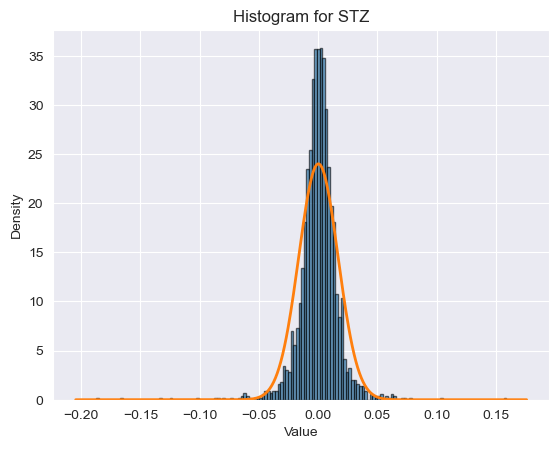

In [93]:
mu, sigma = daily_returns.mean(), daily_returns.std(ddof=1)
fig, ax = plt.subplots()
# “density=True” rescales bar heights so the total area = 1,
# which puts the histogram on the same scale as a PDF.
ax.hist(daily_returns,
bins="auto",           # can also set this manually
density=True,
edgecolor="k",
alpha=0.6)

# make the corresponding normal PDF curve
xmin, xmax = ax.get_xlim()             # span of the plotted data
x = np.linspace(xmin, xmax, 500)
ax.plot(x, norm.pdf(x, mu, sigma),      # norm.pdf evaluates N(mu,sigma**2)
        linewidth=2)


ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.set_title(f"Histogram for {random_ticker}")
plt.show()

Now we'll do it for the full S&P 500

In [94]:
data = yf.download('^GSPC', period="10y")
close = data['Close']
normalized_returns = close/close.iloc[0]-1
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
stock = pd.concat([stock, normalized_returns], axis =1 )

daily_returns = np.log(data['Close']/data['Close'].shift(1))
daily_returns = daily_returns.dropna()

[*********************100%***********************]  1 of 1 completed


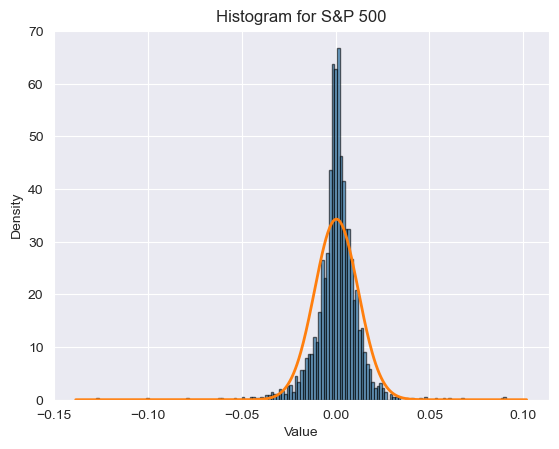

In [96]:
mu, sigma = daily_returns.mean(), daily_returns.std(ddof=1)
fig, ax = plt.subplots()
# “density=True” rescales bar heights so the total area = 1,
# which puts the histogram on the same scale as a PDF.
ax.hist(daily_returns,
bins="auto",           # can also set this manually
density=True,
edgecolor="k",
alpha=0.6)

# make the corresponding normal PDF curve
xmin, xmax = ax.get_xlim()             # span of the plotted data
x = np.linspace(xmin, xmax, 500)
ax.plot(x, norm.pdf(x, mu, sigma),      # norm.pdf evaluates N(mu,sigma**2)
        linewidth=2)


ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.set_title(f"Histogram for S&P 500")
plt.show()

In [97]:
results = daily_returns.apply(normality_tests).T
for ticker in daily_returns.columns:
    print(ticker, results[ticker])

^GSPC {'Shapiro p': np.float64(1.2872871777013416e-41), 'Jarque-Bera p': np.float64(0.0), 'D-P K^2 p': np.float64(3.05228547560749e-155)}


In [100]:
stats = daily_returns.agg(['mean', 'std', 'skew', 'kurtosis']).T
print(stats.round(3))


        mean    std  skew  kurtosis
Ticker                             
^GSPC    0.0  0.012 -0.65    15.525


In [101]:
central95 = daily_returns.quantile([0.025, 0.975])

lower = central95.loc[0.025]
upper = central95.loc[0.975]

#mask = daily_returns.ge(lower) & daily_returns.le(upper)     # element-wise comparisons
#mask_all = mask.all(axis=1)            # row is True only if all 5 conditions hold
mid95 = daily_returns.where(daily_returns.ge(lower) & daily_returns.le(upper)) # each column now contains the middle 95% of the original columns


In [108]:
results = mid95.apply(normality_tests).T
for ticker in mid95.columns:
    print(ticker, results[ticker])

^GSPC {'Shapiro p': np.float64(3.3786693943209e-14), 'Jarque-Bera p': np.float64(8.289304499470193e-12), 'D-P K^2 p': np.float64(9.00685560128498e-11)}


In [103]:
stats = mid95.agg(['mean', 'std', 'skew', 'kurtosis']).T
print(stats.round(3))


         mean    std   skew  kurtosis
Ticker                               
^GSPC   0.001  0.008 -0.305     0.379
